# Project: Gradients and Solvers

## Machine Learning, Fall 2021

### Name: Andrew Wen

### General Sources
* William Yue '22 for help with initializing the gradients np.array in my Variable class
* Michael Hlavaty '23 with graphing data points
* https://realpython.com/python-map-function/ 
* https://dphi.tech/blog/tutorial-on-logistic-regression-using-python/
* https://datascience.foundation/sciencewhitepaper/understanding-logistic-regression-with-python-practical-guide-1
* https://colab.research.google.com/drive/1VC7kP7AeiLt4sA9WFijq758QCe7MkGiF#scrollTo=v1yq7g0ocEdR
* https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

### Black Box Sources
* https://www.pewresearch.org/internet/2017/02/08/code-dependent-pros-and-cons-of-the-algorithm-age/
* https://dallascard.medium.com/the-black-box-metaphor-in-machine-learning-4e57a3a1d2b0

In this project, you'll perform the following tasks:

1. [Explore gradients and contour plots](#Gradients-and-Contour-Plots),
2. [Learn about the notion of a "Blackbox" algorithm](#Learning-about-the-black-box)
2. [Define a `Variable` class](#The-Variable-class) which is used to compute the gradient of an "arbitrary" function,
3. [Test out your `Variable` class](#A-basic-test-of-your-Variable-class) by plotting some more gradients on contour plots, 
4. [Build and test a `LogisticRegression` class](#The-LogisticRegression-class) using your `Variable` class, and 
6. [Explore your fit model to ask questions about the black box](#Exploring-the-black-box)

In [1]:
# Standard import statements:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

plt.style.use("ggplot")

## Gradients and Contour Plots

Let's begin by understanding how contour plots work.  These are 2D representations of functions of two variables (what some people might call "3D functions").  You may be familiar with [contour maps](http://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg); a contour map is simply a contour plot of the function 

$$f(\text{lattitude}, \text{longitude}) = \left<\text{height of the Earth's surface above sea level at that point}\right>.$$ 

More generally, the contours in a plot are the paths of same height.  Thus, traveling perpendicularly to a contour means traveling "straight up or down the mountain".  Here's a first attempt at making a contour plot for a function which somewhat resembles the top of a mountain:

Exception was raised: 
TypeError: Input z must be 2D, not 1D


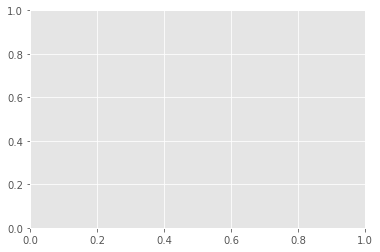

In [2]:
def f(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

# maybe a first guess is:
z = f(x,y)

try:
    plt.contour(x, y, z);
except Exception as e:
    print("Exception was raised: \n", type(e).__name__, ": ", e, sep='')

That doesn't work, because this only plugs values into $f$ which are on the *diagonal*, that is, those values in the $xy$-plane where $x=y$.  In order to make this work, we need a function value over every point in our grid, i.e. every pair of $x$- and $y$-values in the square.  This is why the value for z must be 2D, because its indices `i` and `j` are the indices of its $x$- and $y$-values of its point.  That is, `z[i,j] = f(x[i], y[j])`.

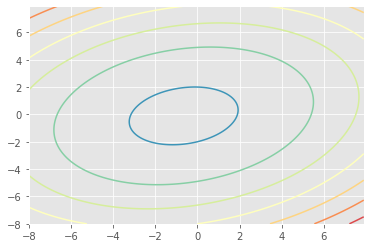

In [3]:
# Better, but super confusing. Try to parse this line:
z = np.array([[f(x[i],y[j]) for i in range(x.shape[0])] for j in range(y.shape[0])])

try:
    plt.contour(x, y, z, cmap='Spectral');
except Exception as e:
    print(e)

That works, but that line defining `z` sure was a slog.  This is where the helper function `np.meshgrid` comes into play:

In [4]:
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

# Convenience for printing 
iters = [('x', x), ('X', X), ('y', y), ('Y', Y), ('z', z) , ('Z', Z)]

for name, var in iters:
    print("The shape of {} is {}".format(name, var.shape))

if (z == Z).all():
    print("\nThese ways work the same")

The shape of x is (160,)
The shape of X is (160, 160)
The shape of y is (160,)
The shape of Y is (160, 160)
The shape of z is (160, 160)
The shape of Z is (160, 160)


So `np.meshgrid` is used to build this `Z` (which is the same as our manually-built `z`).  But what are `X` and `Y`?

In [5]:
## Make sure you understand what the following code is doing!  It will help with understanding X and Y.

for name, var in iters[:4]:
    try:
        snipped = var[:6, :6]
    except:
        snipped = var[:6]
    print('Beginning of {}:\n{}'.format(name, snipped), end='\n\n')

Beginning of x:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of X:
[[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]]

Beginning of y:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of Y:
[[-8.  -8.  -8.  -8.  -8.  -8. ]
 [-7.9 -7.9 -7.9 -7.9 -7.9 -7.9]
 [-7.8 -7.8 -7.8 -7.8 -7.8 -7.8]
 [-7.7 -7.7 -7.7 -7.7 -7.7 -7.7]
 [-7.6 -7.6 -7.6 -7.6 -7.6 -7.6]
 [-7.5 -7.5 -7.5 -7.5 -7.5 -7.5]]



<div style="background-color: #EFDDFF; padding: 10px;">
<p> Describe what you're seeing:</p>
</div>

Here, it appears that X is formed by stacking len(y) copies of x on top of each other, while Y is formed by stacking len(x) copies of y next to each other. Either way, both X and Y end up as len(y) by len(x) matrices. 

Okay, so now that we know how to plot contour plots of functions of 2 variables, let's explore adding some **gradients** to the plot.  First we define a helper function, used to help us draw the arrows on contour plots

In [6]:
def draw_arrow(a, b, c, d, ax=None):
    """ Draw an arrow on a plot.
    
    params:
        a, b -- coordinates of the base of the arrow
        c, d -- vector corresponding to the arrow (starting at the origin)
        ax   -- the matplotlib Axes object on which to draw the arrow.  If none, set to current Axes object.
    """
    ax = ax or plt.gca()
    v_0 = np.array([a,b])
    v_1 = np.array([c,d]) + v_0
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='k')
    plt.annotate('', v_1, v_0, arrowprops=arrowprops)

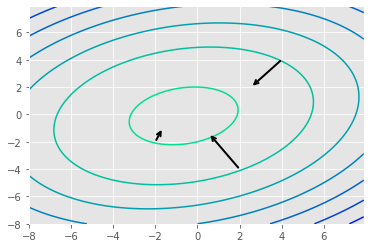

In [7]:
# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

# Draw some gradients
draw_arrow(2, -4, -1.45,  2.6)
draw_arrow(-2, -2, 0.35, 1)
draw_arrow(4, 4, -1.45, -2)

<div style="background-color: #EFDDFF; padding: 10px;">
<p> Okay, so now here's your task. The gradient of the above function happens to be:
$$\nabla f(x,y) = \left<-.4 x + .1 y - .25, -.6 y + .1 x\right>.$$ 

What this means is: at any point $(x, y)$, the gradient is a vector whose $x$- and $y$-components are given by the right-hand side of the equation. You don't need to know how to compute that gradient.
    
Create a function `draw_gradient` that, given a point $(x,y)$, draws the gradient of $f$ at that point.  Then, in the same cell below, recreate the above plot so that your `draw_gradient` method gets called for a handful of randomly-generated points (so that you can rerun the cell and get a new handful of gradient vectors drawn each time).</p>
</div>

In the following code cell, I create a function for drawing the gradient of$$\nabla f(x,y) = \left<-.4 x + .1 y - .25, -.6 y + .1 x\right>$$and call some random 4 points to run the gradient at. 

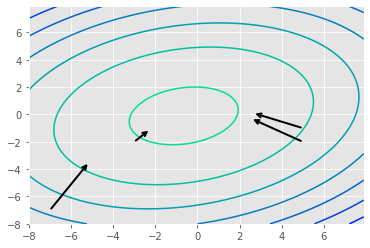

In [8]:
#function for drawing a specific gradient, namely the one above

def draw_gradient(x, y):
    draw_arrow(x, y, -0.4*x + 0.1*y - 0.25, -0.6*y + 0.1*x) # at (x, y), draw the arrow (0.1*y - 0.25, -0.6*y + 0.1*x)
    
plt.contour(x, y, Z, cmap='winter')

# test cases    
n = 4 # subject to change 
for i in range(n):
    draw_gradient(np.random.randint(-8, 8), np.random.randint(-8, 8))

<div style="background-color: #EFDFDF; padding: 10px;">

<h3> Rules for Gradients:</h3>

<p>As we have seen, the gradient is a function that points us "up the hill", in the direction of steepest increase of a function $f$.  What does that mean?  It's important to keep in mind that if you have a function $f$ then the gradient of $f$, written as $\nabla f$, is a different function that takes in points from the same space $f$ does and outputs a vector which points up toward the direction of steepest increase at that point.</p>

<p>Below are all the rules that we will need for our gradients.  In a multivariable calculus class, you would study and possibly even prove these statements.  For us, we'll take them as our programming requirements: the gradient is simply a recursive function with a bunch of rules.  <strong>Do not feel like you need to memorize these for my class, or understand where they come from. I will never ask you to compute the gradient of a function by hand.</strong></p>

<ul>
<li> If $x_i$ is the $i^{\text{th}}$ independent variable, then $\nabla x_i = \left<0,\ldots,0,1,0,\ldots, 0\right>$, where the $1$ is in the $i^{\text{th}}$ slot.  Another way to say this is the following.  Suppose my function $f$ just picked out the $i^{\text{th}}$ variable: $f(x_1, \ldots, x_p)=x_i$, for some $i$.  Then the gradient of $f$ would be length 1 and would point in the $x_i$-direction.</li>
<li> The gradient is <strong>linear</strong>: </li><ul>
 <li> If $f(x_1, \ldots, x_p) = w_1+w_2$, then $\nabla f = \nabla w_1 + \nabla w_2$, and </li>
 <li> If $f(x_1, \ldots, x_p) = c \cdot w$, then $\nabla f = c \cdot \nabla w$.</li>
 <li> (As an extension of the first point: if $f(x_1, \ldots, x_p) = \sum_{i=1}^n w_i$, then $\nabla f = \sum_{i=1}^n\nabla w_i$.)</li>
 </ul>
<li> The gradient has a <strong>power rule</strong>: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w^n$ then $\nabla f = n w^{n-1} \cdot \nabla w$, </li>
 </ul>
<li> The gradient has a <strong>product rule</strong>: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1\cdot w_2$ then $\nabla f = w_1 \cdot \nabla w_2 + w_2 \cdot \nabla w_1$,</li>
 </ul>
    <li> The gradient does have a <em>difference rule</em> and a <em>quotient rule</em>, but you can just define yours using the facts that $w_1 - w_2 = w_1 + (-1) \cdot w_2$ and $\dfrac{w_1}{w_2} = w_1 \cdot (w_2)^{-1}$, respectively.</li>
<li> The gradient has a <strong>chain rule</strong>, which manifests itself in the following ways (the only ones we'll need):</li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = e^w$ then $\nabla f = e^w \cdot \nabla w$,</li>
 <li> If $f(x_1, \ldots, x_p) = \ln(w)$ then $\nabla f = \frac{1}{w} \cdot \nabla w$, </li>
 <li> There are lots of others, but we won't need them for now. </li>
 </ul>
</ul>
</div>

# Learning about the black box

One of the most common conversation points written about machine learning, and artificial intelligence more generally, is the notion that machine learning algorithms are "black boxes". Roughly, this means that the programmer creates the code which _trains_ the algorithm, runs that training code, then has _no idea_ what's going on "inside the box" of their machine learning model. Another goal for you in this project is to gain a more nuanced understanding of this argument. I want you to do a little bit of research now, and then explore later, the following questions:

* What does it mean to say that the creator of a machine learning model "doesn't know what's going on inside their algorithm"? What don't they know? _(hint: it has to do with parameters.)_
* Do machine learning model creators truly have _no idea_ what happens in their models? Perhaps, by default they don't? Or, in practice, they don't? 

You can find whatever resources you want on this topic (and if you find a resource you especially like, _definitely_ share with us all!). Here are some articles for you to explore if you need some help.

* [The dangers of trusting black-box machine learning](https://bdtechtalks.com/2020/07/27/black-box-ai-models/), by Ben Dickson
* [Code-Dependent: Pros and Cons of the Algorithm Age](https://www.pewresearch.org/internet/2017/02/08/code-dependent-pros-and-cons-of-the-algorithm-age/)By Lee Rainie and Janna Anderson. This article is HUGE, and covers many conversations. The point we're looking for in here is the last one, "Theme 7: The need grows for algorithmic literacy, transparency and oversight".
* [Machine Learning Algorithms are Not Black Boxes](https://towardsdatascience.com/machine-learning-algorithms-are-not-black-boxes-541ddaf760c3), by Zach Monge. This explores neural networks, which we haven't covered yet, but for now, just know that they are very similar to linear and logistic regression, just with thousands of parameters instead of just a handful ($m$ and $b$, or in a multidimensional version, $m_1, m_2, \ldots, m_m$, and $b$).

<div style="background-color: #EFDDFF; padding: 10px;">
    <p>Provide a reflection here about your findings.</p>
    </div>

A bit of stuff I learned from doing research on the concept of black boxes: a machine learning system has a model and a machine learning algorithm. The model takes in a certain set of inputs, and returns a certain set of outputs. The algorithm trains the model on datasets and more to make sure the model becomes more accurace and sort of trains/learns to output more accurately. The reason behind this algorithmic process of training the model is called a "black box" is because it is hard to justify what is going on during this training process, i.e what data the model is chosen to train on, how the parameters of the model are being modified as the model is being trained, etc.  

A good example of this is that, say a human crashes a car on the side of the road. If you ask the human why he did so, he could provide you with a reasonable explanation like "I was drunk driving accidentally because I was at a party and was also super depressed by work/life etc. and wanted to stop thinking about all that for a little bit." If a automated car crashes into the side of the road, it's only feasible explanation is "the data I was trained on made it seem like this was the best option" where the definition is ambigious, and it is not clear whether the car was even trained on approppriate data; i.e it all does not make sense. While a human could provide rationale, a machine learning algorithm cannot always necessarily provide the rationale behind its decision making. 

- The creator of a machine learning model might not know what is going on inside their algorithm because they might not have been the ones who wrote the algorithm. Even if they did, they would not know exactly the details of how the model was being fit, hence the process that trains the model and is the reason behind why certain inputs return certain outputs is unknown, hence this model algorithm process being called a "black box"
- Machine learning model creators at least have an idea of what the objective of their model is, but they may not necessarily know how exactly the model achieves that objective. 

Anyways, the black box nature of machine learning algorithms is dangerous because the process used to train the data could potentially be dangerous, and the model would output dangerous and/or incorrect results. 

## The `Variable` class

Your main task in the project is to make a `Variable` class.  The `Variable` class is a node in the computational graph.  It should have the following attributes and methods:

* an `__init__` method,
* an `evaluate` method that allows you to evaluate the variable at a given value of the primitive (independent) variables,
* a `grad` method that will compute return the gradient at a given value.  Here, you should use a numpy array. This might sound scary, but the main reason is so that you can compute with them nicely, later (see my implementation of a `grad` method below).  For example, to do this for $f(x_1, x_2, x_3) = x_1$, that `Variable`'s gradient function should `return np.array([1,0,0])`
* appropriate methods/functionality to calculate the gradients and function evaluation for all the gradients defined above.
* _(Optional)_ I found it helpful to have a class attribute called `all_variables` which is a list that keeps track of all the Variable objects in the order of creation.  There are fancy technical definitions and requirements of such a list, technically called a _Wengert list_, but for you it could just be a list that holds all your `Variable` objects (so in the constructor, you should append `self` to the list). You definitely may not need this, but some people benefit from making it. 
 * If you do make this, you'll likely need a class method which resets the list to an empty list.  This allows you to redefine the expression each time you create a new computational graph. Google `@staticmethod` to see the notation.
* _(old, replaced by dictionary version_ an attribute `inputs`, a list that records which inputs the current `Variable` objects takes.  This could highly leverage your wengert list.

As an example, if I were to say:

```
>>> x = Variable()
>>> y = Variable()
>>> z = x + y
```

This will create a new `Variable` class for `z`, and initialize it appropriately, and give it the ability to take its gradient.  The way we can implement this is by defining a *magic* method called `__add__`.  Magic methods in Python are what give it such a great, readable API.  Here's an example `__add__` method, based on how I set up my constructor.  Yours might be a little bit different:

```
    def __add__(self, other):
        """ Defines the functionality of the `+` operator. """
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(
                                evaluate = lambda values: other + self.evaluate(values), 
                                grad = self.grad
                            )
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(
                                evaluate = lambda values: self.evaluate(values) 
                                    + other.evaluate(values),
                                grad = lambda values: self.grad(values) 
                                    + other.grad(values)
                           )
        else:
            return NotImplemented
```

See [this link](http://www.diveintopython3.net/special-method-names.html#acts-like-number) to learn about the magic methods you will need to implement.

The theory here is that you create the "ugly" `x.__add__(y)`-ish code once and only once, and then when you use the code later it's much more readable: `x + y`.  You'll need to do something like this for all the operations discussed above in the [gradients section](#-Rules-for-Gradients:).  The exception is for functions like `exp` and `log` (and if I wanted you to do other things, like `sin`, `cos`, `tan`, _etc._).  Those will need to be class methods.  They should still return a new `Variable` object.  See below for the API that they should support.

Other methods you need to implement:

* While you do need to have an `evaluate` method, if you also implement the `__call__` method (make it just call `evaluate`) then you can replace code of the form `w.evaluate({"x_1": 4, "x_2": 2, "x_3": 8.5})` with `w(x_1 = 4, x_2 = 2, x_3 = 8.5)`, which is both cleaner and looks like function notation (which is desirable because the `w`'s really can be thought of as functions of the independent variables).
* You might want to implement the `__repr__` method so that you can print out your variables (as in, just `print(x)`).  It would be especially nice if printing out a `Variable` object gave you a graph traversal of its `inputs`.  It's okay here if it looks like a tree, _i.e._ nodes get repeated.  It would be a bit too much work to make the true graph visual happen.
* You will need to implement the methods `__radd__` and `__rmul__`, _etc._ that give your `__add__` and `__mul__` method more functionality.  This allows expressions like `2 + x` instead of always requiring that a user use the `Variable` object first: `x + 2`.  In your research, you may see `__iadd__` and `__imul__`, and those you _should_ skip.

Here are some resources that may help you along the way:
* A good explanation on [Automatic Differentiation](https://pdfs.semanticscholar.org/be3d/17df872d41465dabda2fc9a9a61394658a1a.pdf) (the name of this process).  It's probably _much_ more information than you need.
* There's always [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation).
* Another take on [operator overloading in Python](http://blog.teamtreehouse.com/operator-overloading-python).

## A "complete" collection of uses that demonstrates the API 
Suppose my function is: 

$$f(x_1, x_2, x_3) = e^{x_1 + {x_2}^2} + 3 \cdot \ln(27 - x_1\cdot x_2 \cdot x_3).$$

Then the following code would build and test my function. The first line might be different for you, depending on how you create the `exp` and `log` functions:

```
>>> from Variable import exp, log
>>> x_1 = Variable(name = "x_1")
>>> x_2 = Variable(name = "x_2")
>>> x_3 = Variable(name = "x_3")
>>> z = exp(x_1 + x_2**2) + 3 * log(27 - x_1 * x_2 * x_3)
>>> # Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z(x_1 = 3, x_2 = 1, x_3 = 7)
59.9734284408284
>>> # Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z.grad(x_1 = 3, x_2 = 1, x_3 = 7)
array([ 51.09815003,  98.69630007,  -1.5       ])
>>> print(x_1 + x_2**2)
+(
 1: <input 1>
 2: ^2(
  <input 2>
 )
)
```
Two notes: 
1. I had to do some pencil-and-paper math on that gradient, let me know if it's not what you got!
2. The print-out is optional, but helpful!  You can make it say whatever you want.  Here, I made it list the node type, then indent the inputs of that node by one, recursively.  It almost looks a bit like [prefix notation](https://en.wikipedia.org/wiki/Polish_notation).

## Some thoughts on coding process

* I recommend that you don't actually define the class in a single cell in this notebook.  It's going to get a bit big, and it's going to be difficult to work on it together if it's in a cell on a jupyter notebook.  I believe that a better strategy for designing this class is to have a Python file `variable.py`, located in the same folder as this notebook and opened in your favorite text editor that contains your `Variable` class, and then just rerun a cell like this to reimport it here after saving over there:

* Then, when you change something and want to check out how it works, just rerun the above cell.
* This also makes sharing code via something like github a lot easier!
* I _highly recommend_ you begin by making everything other than gradients work, and then add gradients afterward. It will be **much** easier to understand.
* I also _highly recommend_ that you make it take in one-dimensional data at first (so that the parameters are just $m$ and $b$), and then allow for multidimensional inputs. For top marks on this assignment, one would need to add in multidimensional support, but it is a bit confusing to do so, and you will get almost complete understanding of the assignment by starting with one dimension.

In [9]:
from variable import Variable

Now let us test out our Variable class with a few examples with a few functions an some .evaluate() and .gradient() calls.

In [10]:
x_1 = Variable(name = "x_1")
x_2 = Variable(name = "x_2")
x_3 = Variable(name = "x_3")
z = Variable.exp(x_1 + x_2**2) + 3 * Variable.log(27 - x_1 * x_2 * x_3)

z.gradient({"x_1": 3, "x_2": 1, "x_3": 7})

array([51.09815003, 98.69630007, -1.5       ])

In [11]:
x_1 = Variable(name = "x_1")
x_2 = Variable(name = "x_2")
x_3 = Variable(name = "x_3")
x_4 = Variable(name = "x_4")

z = Variable.exp(x_1 + x_2**2 - x_3 + 2*x_4) + 3 * Variable.log(x_4**3 - x_1 * x_2 * x_3) - x_1/x_2 + x_3/x_4

z.gradient({"x_1": 3, "x_2": 1, "x_3": 7, "x_4": 5})

array([ 1095.43123535,  2195.66054763, -1096.51969689,  2195.1497784 ])

Now let's do some plotting and graphing with the new functions from our Variables class! We will be plotting gradients for the function$$f(x, y) = 1.5 - 0.3xy + 0.1x^2 + 0.2y^2 - 3x + 2y$$whose countour is shown in the background. 

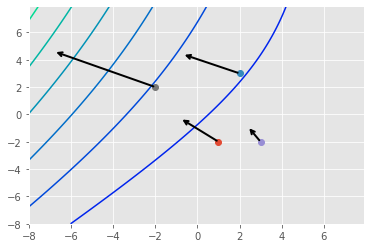

In [12]:
def f(x,y):
    return 1.5 - 0.3*x*y + 0.1*x**2 + 0.2*x**2 - 3*x + 2*y

x_axis = np.arange(-8,8,.1)
y_axis = np.arange(-8,8,.1)
X, Y = np.meshgrid(x_axis, y_axis)
Z = f(X,Y)

plt.contour(x_axis, y_axis, Z, cmap = 'winter')

x = Variable(name = "x")
y = Variable(name = "y")
z = 1.5 - 0.3*x*y + 0.1*x**2 + 0.2*x**2 - 3*x + 2*y

def draw_the_gradient(x,y,ax=None):
    ax = ax or plt.gca()
    draw_arrow(x,y,*z.gradient({"x":x, "y":y}),ax=ax)
    ax.plot(x,y,marker='o')
    
for _ in range(4):
    draw_the_gradient(np.random.randint(-4,4), np.random.randint(-4,4))


Perfect!

## The `LogisticRegression` class

Now that you have the class needed for creating a gradient, it's time to put it to use.  Construct a `LogisticRegression` class that serves as a logistic regression model.  It should support the standard Scikit-Learn API:

```
>>> X,y = <some dataset consisting numpy arrays in the standard form>
>>> model = LogisticRegression()
>>> model.fit(X, y)
>>> X_test, y_true = <some test dataset in the standard form>
>>> y_preds = model.predict(X_test)
>>> from sklearn.metrics import accuracy_score
>>> accuracy_score(y_true, y_preds)
```

Use your `Variable` class in the `fit` method of your class (or wherever else seems appropriate).  Remember, you're taking the gradient of the cost function, and the cost function has as its inputs the parameters of your model.  So you should have a `Variable` for every model parameter.  You **don't** need to support multi-class predictions (as in, you can assume your output variable `y` is binary), and it is **optional** to support a multidimensional `X` (as in, perhaps my dataset has 7 predictors, and I want to be able to use your class to fit my data).

You should fit your model to some data in order to (thoroughly!) test your model.

**Note**: I recognize that you could just take the partial derivatives (or google them), but that's not the point of this project!  The goal is to struggle through both creating _and_ using your `Variable` class.

In [13]:
from logistic_regression import LogisticRegression

Having written our Logistic Regression class, we can now test it out on some pairs of datasets X and output y, where we can also play around with the learning rates and number of iterations we wish for the gradient descent to run. Let's first play around with a dataset we made ourselves.

In [99]:
model = LogisticRegression(0.0001, 1000)
X = [[0], [0.25], [0.6], [1], [1.15], [1.3], [1.75], [2], [2.4], [3], [4], [5], [6], [7], [8], [9]]
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
model.n_fit(X, y, 10, 0.0001, 1000)

result = model.predict_n_fit(X)
print(result)

from sklearn.metrics import accuracy_score
score = accuracy_score(y, [p>0.5 for p in result])
print(score)

Cost is: 9.585525003041251
{'m_0': 0.1432265350714396, 'b': -0.22528670175863194}
Cost is: 9.66493908479362
{'m_0': 0.12408800934941036, 'b': -0.21491561152257604}
Cost is: 9.780191070699583
{'m_0': 0.10582635108825145, 'b': -0.1991409635600514}
Cost is: 9.925728784810458
{'m_0': 0.08831526024023063, 'b': -0.17836719525420866}
Cost is: 10.097061608802441
{'m_0': 0.07143511146179192, 'b': -0.1529975275716713}
Cost is: 10.29066537222051
{'m_0': 0.05507472259245428, 'b': -0.12341962812145614}
Cost is: 10.50385342960903
{'m_0': 0.039132280778142764, 'b': -0.08999611782026166}
Cost is: 10.734638798130558
{'m_0': 0.023515623921870964, 'b': -0.053059115453791834}
Cost is: 10.981602888903234
{'m_0': 0.008142067511527122, 'b': -0.012907877671385817}
Cost is: 11.24377892421639
{'m_0': -0.007062062521936607, 'b': 0.03019135129163164}
Cost is: 11.520553020514926
{'m_0': -0.02216206640492414, 'b': 0.0760040195334454}
Cost is: 11.811582826944175
{'m_0': -0.03721558635136379, 'b': 0.12432504776804969

Cost is: 11.301752874865251
{'m_0': -0.004918455005832751, 'b': 0.054948377110538425}
Cost is: 11.575374020309859
{'m_0': -0.020611815109877776, 'b': 0.09852687003471754}
Cost is: 11.864592239660858
{'m_0': -0.036180503037629944, 'b': 0.14495821528741468}
Cost is: 12.16894201524434
{'m_0': -0.05168616892221181, 'b': 0.1940173440218547}
Cost is: 12.488194145179268
{'m_0': -0.067182871763517, 'b': 0.24550840135460764}
Cost is: 12.822294861875182
{'m_0': -0.08271786321871158, 'b': 0.29926157227892347}
Cost is: 13.17131798138045
{'m_0': -0.09833232451973775, 'b': 0.3551298869619659}
Cost is: 13.535427439379344
{'m_0': -0.11406204101131986, 'b': 0.41298615011906076}
Cost is: 13.914847937495564
{'m_0': -0.12993800810009398, 'b': 0.47272007810946015}
Cost is: 14.309841836604217
{'m_0': -0.1459869683283592, 'b': 0.5342356865955701}
Cost is: 14.720690825771548
{'m_0': -0.16223188286995358, 'b': 0.597448945286753}
Cost is: 15.147681237340416
{'m_0': -0.17869234275550977, 'b': 0.6622856999593669}

Cost is: 24.22802848593386
{'m_0': -0.48716080375366244, 'b': 1.8222242638258348}
Cost is: 24.938771430501262
{'m_0': -0.5071509449230892, 'b': 1.9111002976939142}
Cost is: 25.665460864969116
{'m_0': -0.5275112384314754, 'b': 2.0003188928227105}
-----------------

The minimum value of the cost function is 15.133218302295282 occurs when
{'m_0': -0.2365896186884034, 'b': 0.15599429874541182}
-----------------

Cost is: 12.11473022126013
{'m_0': 0.3969105171323972, 'b': -0.015610489019054886}
Cost is: 11.470795347731329
{'m_0': 0.3641019170479446, 'b': -0.06469461044298214}
Cost is: 10.92559628620628
{'m_0': 0.3329328771361999, 'b': -0.10843870244352694}
Cost is: 10.477516110027336
{'m_0': 0.3034109598942432, 'b': -0.1463961265418871}
Cost is: 10.122892228583897
{'m_0': 0.2755203935007005, 'b': -0.17819350155434777}
Cost is: 9.85613497725618
{'m_0': 0.24922065290366793, 'b': -0.20355875092224174}
Cost is: 9.670064702402762
{'m_0': 0.2244467648372281, 'b': -0.22234124323196175}
Cost is: 9.

Next, a multidimensional one:

In [17]:
model = LogisticRegression(0.001, 5000)
model.fit([[0, -2], [1,0], [3, 1], [2, 5], [1.5, 6]], [0,1,1,1,1]) 
model.n_fit([[0, -2], [1,0], [3, 1], [2, 5], [1.5, 6]], [0,1,1,1,1], 10, 0.001, 2500)  

result = model.predict_n_fit([[0, -2], [1,0], [3, 1], [2, 5], [1.5, 6]])
print(result)

from sklearn.metrics import accuracy_score
score = accuracy_score([0, 1, 1, 1, 1], [p>0.5 for p in result])
print(score)

Cost is: 4.709730725184722
{'m_0': 0.09206286114770128, 'm_1': -0.2367554387730904, 'b': 0.2364978211693354}
Cost is: 2.8155155293480485
{'m_0': 0.14746552912261762, 'm_1': -0.07344515374611539, 'b': 0.6193172073921397}
Cost is: 2.187494772006977
{'m_0': 0.16809114850469228, 'm_1': 0.026184372058695785, 'b': 0.8595737848566725}
Cost is: 1.9294369484743605
{'m_0': 0.1717262781852031, 'm_1': 0.09529876028790708, 'b': 1.0322305294721077}
Cost is: 1.8014702639905082
{'m_0': 0.16631486688691804, 'm_1': 0.14849420991020587, 'b': 1.1716941516440338}
Cost is: 1.7316058937537333
{'m_0': 0.1553500981118956, 'm_1': 0.1922065218683372, 'b': 1.2928197594871975}
Cost is: 1.692695763115448
{'m_0': 0.14057843044129387, 'm_1': 0.22967720143229994, 'b': 1.4028513028762886}
Cost is: 1.6725208000626566
{'m_0': 0.1229775351420493, 'm_1': 0.2627374942236625, 'b': 1.5057449626579615}
Cost is: 1.6648272428061655
{'m_0': 0.10314424806489224, 'm_1': 0.2925162821848262, 'b': 1.6038594113649576}
Cost is: 1.666094

Cost is: 6.066303336084856
{'m_0': -2.8278584523179466, 'm_1': 1.505272474731502, 'b': 8.94044235071577}
Cost is: 6.135394717222215
{'m_0': -2.8714437424725245, 'm_1': 1.5239164744616633, 'b': 9.046369233448711}
Cost is: 6.204350520680112
{'m_0': -2.9150110441519423, 'm_1': 1.5426529249725587, 'b': 9.152345567253462}
Cost is: 6.273172216890683
{'m_0': -2.9585602960356168, 'm_1': 1.5614795088367446, 'b': 9.258369353649524}
Cost is: 6.341861469409257
{'m_0': -3.0020914907510186, 'm_1': 1.5803939120533979, 'b': 9.364438677527644}
Cost is: 6.4104201129632
{'m_0': -3.045604669567541, 'm_1': 1.5993938288671976, 'b': 9.47055170313127}
Cost is: 6.478850133017964
{'m_0': -3.089099917472352, 'm_1': 1.6184769661926668, 'b': 9.576706670296014}
Cost is: 6.5471536467863105
{'m_0': -3.13257735860608, 'm_1': 1.6376410476605479, 'b': 9.682901890926175}
Cost is: 6.615332885610451
{'m_0': -3.1760371520370936, 'm_1': 1.6568838173030616, 'b': 9.78913574568883}
Cost is: 6.683390178643777
{'m_0': -3.21947948

Cost is: 1.021444861414214
{'m_0': -0.016825360435413377, 'm_1': 0.7515247686221149, 'b': 0.6806908498878144}
Cost is: 0.9590386511891394
{'m_0': -0.00483287729560552, 'm_1': 0.7982522980028885, 'b': 0.7242983842429939}
Cost is: 0.9059411065501835
{'m_0': 0.005966896247281068, 'm_1': 0.8413249058953374, 'b': 0.7649567816713537}
Cost is: 0.8600299517460913
{'m_0': 0.015765238066339938, 'm_1': 0.8812952769060466, 'b': 0.8032239985225114}
Cost is: 0.8198200514899634
{'m_0': 0.02470559220241894, 'm_1': 0.9185936771131777, 'b': 0.8395044206629719}
Cost is: 0.7842326411310834
{'m_0': 0.032898805950592434, 'm_1': 0.9535632220099867, 'b': 0.8741018847139912}
Cost is: 0.7524601702496826
{'m_0': 0.04043265529201732, 'm_1': 0.9864828520500777, 'b': 0.9072515876293785}
Cost is: 0.7238829860681735
{'m_0': 0.04737806224768277, 'm_1': 1.0175829408355745, 'b': 0.9391401723430193}
Cost is: 0.6980157223758812
{'m_0': 0.05379330468172639, 'm_1': 1.0470562728078436, 'b': 0.9699188716947699}
Cost is: 0.674

Cost is: 0.9842202584188824
{'m_0': -0.4209694938063317, 'm_1': 1.1929287821629317, 'b': 2.5836655792959644}
Cost is: 0.9933699710576557
{'m_0': -0.4397871676893313, 'm_1': 1.2091850981843673, 'b': 2.6427651415191993}
Cost is: 1.0037328880239407
{'m_0': -0.45918626307142696, 'm_1': 1.2250700565475114, 'b': 2.7024613083611664}
Cost is: 1.0153123537513766
{'m_0': -0.4791702082727167, 'm_1': 1.2406076794061536, 'b': 2.7627923241535837}
Cost is: 1.0281153209516438
{'m_0': -0.4997427052257342, 'm_1': 1.2558204739566148, 'b': 2.8237949530837003}
Cost is: 1.0421518952726423
{'m_0': -0.5209076277056458, 'm_1': 1.27072959968601, 'b': 2.885504507852185}
Cost is: 1.0574349109022907
{'m_0': -0.5426689221188419, 'm_1': 1.2853550147437127, 'b': 2.947954852801406}
Cost is: 1.073979527514116
{'m_0': -0.5650305100220633, 'm_1': 1.2997156044282108, 'b': 3.01117838462135}
Cost is: 1.091802840828017
{'m_0': -0.587996191832793, 'm_1': 1.3138292942545722, 'b': 3.0752059934161338}
Cost is: 1.1109235006651028

Cost is: 1.3106254456451027
{'m_0': 0.3572516560020195, 'm_1': 0.27205111324466535, 'b': 0.5245158686543614}
Cost is: 1.2316880232029488
{'m_0': 0.3586900375549676, 'm_1': 0.315212285679473, 'b': 0.6115636322890827}
Cost is: 1.1756146833369419
{'m_0': 0.35720272964971633, 'm_1': 0.3531024933072315, 'b': 0.6901181556762749}
Cost is: 1.1340313572756342
{'m_0': 0.3534967733402288, 'm_1': 0.3870923911360626, 'b': 0.762941578609488}
Cost is: 1.1023521586591902
{'m_0': 0.3480176006209483, 'm_1': 0.4180646277471266, 'b': 0.8317487241447566}
Cost is: 1.0778566327657717
{'m_0': 0.34106114350851974, 'm_1': 0.44662098521725796, 'b': 0.8976705659661368}
Cost is: 1.0588288182539023
{'m_0': 0.3328321340131443, 'm_1': 0.4731906346655897, 'b': 0.9614901578135304}
Cost is: 1.0441331629607287
{'m_0': 0.32347669247683325, 'm_1': 0.49809097041117034, 'b': 1.0237718743629713}
Cost is: 1.0329891586659719
{'m_0': 0.31310163986316913, 'm_1': 0.521563860634065, 'b': 1.0849365475335795}
Cost is: 1.0248439610633

Cost is: 0.5624028221445942
{'m_0': 0.07775765382065129, 'm_1': 1.2397736927439615, 'b': 1.5810672855332697}
Cost is: 0.5572413374457963
{'m_0': 0.07342688226510358, 'm_1': 1.2543754793236401, 'b': 1.6123567093185633}
Cost is: 0.5525388770450453
{'m_0': 0.06882454620982605, 'm_1': 1.2685942130088075, 'b': 1.6436181945919643}
Cost is: 0.5482750652428784
{'m_0': 0.0639527957892802, 'm_1': 1.2824485335013236, 'b': 1.6748724756594087}
Cost is: 0.5444319663242044
{'m_0': 0.058813268984188045, 'm_1': 1.2959557289006112, 'b': 1.7061395110022848}
Cost is: 0.5409938373449545
{'m_0': 0.053407126069317065, 'm_1': 1.309131868248822, 'b': 1.7374385943377169}
Cost is: 0.5379469176789818
{'m_0': 0.04773507903237244, 'm_1': 1.3219919182542266, 'b': 1.7687884531450324}
Cost is: 0.5352792495456254
{'m_0': 0.04179741668976792, 'm_1': 1.3345498464468035, 'b': 1.8002073366373992}
Cost is: 0.532980524810913
{'m_0': 0.035594026099614796, 'm_1': 1.3468187126516935, 'b': 1.8317130948067029}
Cost is: 0.53104195

Cost is: 1.3070343881329407
{'m_0': 0.11847881211020744, 'm_1': 0.5138380698582705, 'b': 0.1496364728459488}
Cost is: 1.1760591484193388
{'m_0': 0.14098620929624608, 'm_1': 0.578049918075513, 'b': 0.2084564752392404}
Cost is: 1.0778270540551569
{'m_0': 0.16057026221920795, 'm_1': 0.6346392644768589, 'b': 0.25838502114825823}
Cost is: 1.0001766434072659
{'m_0': 0.1780348467767055, 'm_1': 0.685459622419743, 'b': 0.3022532963478431}
Cost is: 0.936513071357662
{'m_0': 0.19387710160982416, 'm_1': 0.7317180413634278, 'b': 0.3417227154162007}
Cost is: 0.8829134020581834
{'m_0': 0.20842632259648008, 'm_1': 0.7742529843594276, 'b': 0.37784229510769585}
Cost is: 0.8368739441413092
{'m_0': 0.22191262070834758, 'm_1': 0.8136758821273548, 'b': 0.4113140239381721}
Cost is: 0.7967066092061276
{'m_0': 0.2345037937782017, 'm_1': 0.8504495960273206, 'b': 0.44263034228959375}
Cost is: 0.7612223595636182
{'m_0': 0.2463264934015248, 'm_1': 0.8849349628690347, 'b': 0.47215038025245964}
Cost is: 0.7295534906

Cost is: 1.8170985141175062
{'m_0': -0.6604405477925042, 'm_1': 0.9300298835347536, 'b': 3.2899428910668695}
Cost is: 1.853735631106649
{'m_0': -0.6928115816499006, 'm_1': 0.9478678564475498, 'b': 3.3762348474918378}
Cost is: 1.892084171493219
{'m_0': -0.7257675087458121, 'm_1': 0.9654448307458064, 'b': 3.4632257560197033}
Cost is: 1.9320976665450493
{'m_0': -0.759290682549447, 'm_1': 0.9827868342692395, 'b': 3.5509194976071727}
Cost is: 1.9737294879033962
{'m_0': -0.7933632374888528, 'm_1': 0.9999180661586051, 'b': 3.639316519520872}
Cost is: 2.016932488260899
{'m_0': -0.8279670799009128, 'm_1': 1.0168610809712018, 'b': 3.7284141646767712}
Cost is: 2.061658756007875
{'m_0': -0.8630838971197669, 'm_1': 1.033636944218746, 'b': 3.8182069792696445}
Cost is: 2.107859466924536
{'m_0': -0.8986951814833719, 'm_1': 1.0502653643867785, 'b': 3.9086870031991507}
Cost is: 2.1554848182869755
{'m_0': -0.9347822663676509, 'm_1': 1.066764805523961, 'b': 3.9998440462037115}
Cost is: 2.204484032412469
{

Now let's play around with a fake but pretty large dataset which predict whether an applicant can get into Harvard given some stats, 

In [18]:
import pandas as pd
application = {'APPLICATION_NBR': ['oJCvIoTB', 'q4ICdH0f', '34EK9wXH', 'T83EGu9A', 'tpGQZJDm', 'zHbdj4hS', 'AodXvUsc', 'QE3wAy9T', 'gBa6psw3', 'X7H38FHe', 'iwVeBGu3', 'AMc5dykm', 'cAJ0MbEh', 'sXoTwUHx', 'Fsv0RQA3', 'mJXu1o6R', 'xL3EDeGa', 'c0Ed7hbm', 'LInGqJ59', 'lSKXvwGK', 'xTlGMUG2', 'DvZ2TcBB', 'm67QrLB0', '2YuxgSLF', 'jUHD7lQg', 'Df38sD1D', 'uBewE4el', 'yQduYqfd', 'xs1TTyDO', 'HNHSkiLV', 'DSvTzs8J', 'pIboghkI', 'wL2gVzRP', 'gaR3nmER', 'kfZWQwyh', 'kcDoPfu1', 'GHDbDtEE', 'sZv1NmY5', '68lmOgBL', 'jGjMFKRV', 'GHDbDtFE', 'sZ31NmY5', '682mOgbL', 'jGjMFLRV'],
              'GMAT_SCORE': [640, 650, 580, 620, 780, 750, 690, 710, 680, 730, 690, 720, 740, 690, 610, 690, 710, 680, 770, 610, 580, 650, 540, 590, 620, 600, 550, 550, 570, 670, 660, 580, 650, 660, 640, 620, 660, 660, 680, 650, 670, 580, 590, 690], 
              'GPA': [3, 3.7, 2.7, 3.3, 4, 3.9, 3.3, 3.7, 3.9, 3.7, 2.3, 3.3, 3.3, 1.7, 2.7, 3.7, 3.7, 3.3, 3.3, 3, 2.7, 3.7, 2.7, 2.3, 3.3, 2, 2.3, 2.7, 3, 3.3, 3.7, 2.3, 3.7, 3.3, 3, 2.7, 4, 3.3, 3.3, 2.3, 2.7, 3.3, 1.7, 3.7], 
              'EXPERIENCE': [1, 6, 2, 2, 3, 4, 3, 5, 4, 6, 1, 4, 5, 1, 3, 5, 6, 4, 3, 1, 4, 6, 2, 3, 2, 1, 4, 1, 2, 6, 4, 2, 6, 5, 1, 2, 4, 6, 5, 1, 2, 1, 4, 5], 
              'STATUS': ['Rejected', 'Approved', 'Rejected', 'Approved', 'Approved', 'Approved', 'Rejected', 'Approved', 'Rejected', 'Approved', 'Rejected', 'Approved', 'Approved', 'Rejected', 'Rejected', 'Approved', 'Approved', 'Rejected', 'Approved', 'Rejected', 'Rejected', 'Approved', 'Rejected', 'Rejected', 'Approved', 'Rejected', 'Rejected', 'Rejected', 'Rejected', 'Approved', 'Approved', 'Rejected', 'Approved', 'Approved', 'Rejected', 'Rejected', 'Approved', 'Approved', 'Approved', 'Rejected', 'Rejected', 'Rejected', 'Rejected', 'Approved']
              }

In [19]:
df = pd.DataFrame(application,columns= ['APPLICATION_NBR', 'GMAT_SCORE', 'GPA','EXPERIENCE','STATUS'])
df.head()

,APPLICATION_NBR,GMAT_SCORE,GPA,EXPERIENCE,STATUS
0,oJCvIoTB,640,3.0,1,Rejected
1,q4ICdH0f,650,3.7,6,Approved
2,34EK9wXH,580,2.7,2,Rejected
3,T83EGu9A,620,3.3,2,Approved
4,tpGQZJDm,780,4.0,3,Approved


In [20]:
X = []
for i in range(0, 44):
    X.append([application['GMAT_SCORE'][i], application['GPA'][i], application['EXPERIENCE'][i]])
    
print(X)

y = []
for i in range(0, 44):
    if(application['STATUS'][i] == 'Rejected'):
        y.append(0)
    elif(application['STATUS'][i] == 'Approved'):
        y.append(1)

print(y)

[[640, 3, 1], [650, 3.7, 6], [580, 2.7, 2], [620, 3.3, 2], [780, 4, 3], [750, 3.9, 4], [690, 3.3, 3], [710, 3.7, 5], [680, 3.9, 4], [730, 3.7, 6], [690, 2.3, 1], [720, 3.3, 4], [740, 3.3, 5], [690, 1.7, 1], [610, 2.7, 3], [690, 3.7, 5], [710, 3.7, 6], [680, 3.3, 4], [770, 3.3, 3], [610, 3, 1], [580, 2.7, 4], [650, 3.7, 6], [540, 2.7, 2], [590, 2.3, 3], [620, 3.3, 2], [600, 2, 1], [550, 2.3, 4], [550, 2.7, 1], [570, 3, 2], [670, 3.3, 6], [660, 3.7, 4], [580, 2.3, 2], [650, 3.7, 6], [660, 3.3, 5], [640, 3, 1], [620, 2.7, 2], [660, 4, 4], [660, 3.3, 6], [680, 3.3, 5], [650, 2.3, 1], [670, 2.7, 2], [580, 3.3, 1], [590, 1.7, 4], [690, 3.7, 5]]
[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]


In [127]:
model = LogisticRegression(0.00001, 5000)
model.fit(X, y)
result = model.predict_fit(X)

from sklearn.metrics import accuracy_score
score = accuracy_score(y, [p>0.5 for p in result])
print(score)

Cost is: 9.236750046880639
{'m_0': 0.25221231537196953, 'b': -0.3324797521620607}
Cost is: 9.221386645210963
{'m_0': 0.24987619721961052, 'b': -0.33412419866174486}
Cost is: 9.206693870221649
{'m_0': 0.24755394774874334, 'b': -0.3357062661143241}
Cost is: 9.192663806868262
{'m_0': 0.2452454734424415, 'b': -0.3372260006074604}
Cost is: 9.179288508965598
{'m_0': 0.24295067924035804, 'b': -0.3386834590940646}
Cost is: 9.166560004140509
{'m_0': 0.2406694685788609, 'b': -0.34007870928992856}
Cost is: 9.154470298747617
{'m_0': 0.23840174343196188, 'b': -0.3414118295623567}
Cost is: 9.143011382740536
{'m_0': 0.23614740435298023, 'b': -0.3426829088100671}
Cost is: 9.132175234491617
{'m_0': 0.23390635051688985, 'b': -0.34389204633464426}
Cost is: 9.12195382555337
{'m_0': 0.23167847976328867, 'b': -0.3450393517038399}
Cost is: 9.112339125355001
{'m_0': 0.22946368863993644, 'b': -0.34612494460703136}
Cost is: 9.103323105827789
{'m_0': 0.22726187244680177, 'b': -0.3471489547031564}
Cost is: 9.0948

Now let's have a little bit of fun and predict probabilities of admission for data points not in the given dataset.

In [42]:
model = LogisticRegression(0.00005, 2500)
model.fit(X, y)
model.predict_fit([[650, 3, 4]])

Cost is: 688.3300877483981
{'m_0': -0.050629044244074176, 'm_1': 0.6247188195226132, 'm_2': 0.04791362382240047, 'b': -0.3435615358793075}
Cost is: 26.637660509702766
{'m_0': -0.04118324650744171, 'm_1': 8.406965325659577, 'm_2': 0.08469115730636732, 'b': -0.2721329397906258}
Cost is: 27.295790669679967
{'m_0': -0.04298299512626839, 'm_1': 8.76680559033355, 'm_2': 0.0822307192104316, 'b': -0.24585486801987377}
Cost is: 27.968887371963756
{'m_0': -0.04477885921902041, 'm_1': 9.126031584720312, 'm_2': 0.07966129350901914, 'b': -0.2196794581585867}
Cost is: 28.655488550668135
{'m_0': -0.04657103704275642, 'm_1': 9.48467398986518, 'm_2': 0.0769926696054539, 'b': -0.19359684373193092}
Cost is: 29.354310319167904
{'m_0': -0.0483597229195266, 'm_1': 9.842763749804403, 'm_2': 0.07423353975750613, 'b': -0.1675985089428917}
Cost is: 30.064223005073355
{'m_0': -0.05014510855541065, 'm_1': 10.200332127685165, 'm_2': 0.0713916467118762, 'b': -0.14167704385323243}
Cost is: 30.784230788506115
{'m_0':

[0.18197804477164062]

Since we were running on a pretty large dataset in the previous example, depending on the randomly chosen starting point of the gradient descent, we could run into domain errors if any y_hat values become small and get rounded to 0. Let's test the accuracy of our regression fit model on a more tame dataset, like the one shown below:

In [43]:
X = [[-4, -5, -2], [-3, -2, 0], [1, 1, 0], [2, 4, 3], [9, 8, 4], [10, 3, 10], [9, 9, 9], [11, 8, 10], [12, 14, 14], [21, 10, 18]]
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

model = LogisticRegression(0.00005, 5000)
model.n_fit(X, y, 5, 0.00005, 5000)
predictions = model.predict_n_fit(X)

from sklearn.metrics import accuracy_score
score = accuracy_score(y, [p>0.5 for p in predictions])
print('Accuracy score: ')
print(score)   
      

Cost is: 3.1084196012589325
{'m_0': 0.2402689639070888, 'm_1': -0.21418894498597546, 'm_2': 0.14935600139178212, 'b': -0.2207661169336781}
Cost is: 2.9186212788832835
{'m_0': 0.23780989096868407, 'm_1': -0.1935933741191487, 'm_2': 0.1660003184583555, 'b': -0.2081118408897863}
Cost is: 2.81876817691487
{'m_0': 0.2349729229167359, 'm_1': -0.17706021212159043, 'm_2': 0.17857575649733007, 'b': -0.19910393150127828}
Cost is: 2.7617569139514444
{'m_0': 0.23189315120070875, 'm_1': -0.16312388631661678, 'm_2': 0.18853570818219345, 'b': -0.19237400218818054}
Cost is: 2.727836971090496
{'m_0': 0.22864466329133792, 'm_1': -0.15098615959692782, 'm_2': 0.19667236246881226, 'b': -0.1871931766165401}
Cost is: 2.7074565763831795
{'m_0': 0.22527233299563884, 'm_1': -0.14016580912957696, 'm_2': 0.20346378262119844, 'b': -0.18313064121477818}
Cost is: 2.6955031411271686
{'m_0': 0.2218054018954108, 'm_1': -0.1303502582824962, 'm_2': 0.20922097774768517, 'b': -0.17991133844439056}
Cost is: 2.68902824025774

Cost is: 2.996833562343995
{'m_0': 0.01575809339412941, 'm_1': 0.15424996751362927, 'm_2': 0.23634819179543987, 'b': -0.20298037465972266}
Cost is: 3.0051836848032853
{'m_0': 0.011843861366947057, 'm_1': 0.1593568996739539, 'm_2': 0.23562470546837308, 'b': -0.20358663898969317}
Cost is: 3.0136766206689494
{'m_0': 0.007932105654874419, 'm_1': 0.16449244272003252, 'm_2': 0.23488047738764042, 'b': -0.20416250203406414}
Cost is: 3.022317530941301
{'m_0': 0.0040228953623590415, 'm_1': 0.16965758027000066, 'm_2': 0.23411540486936666, 'b': -0.20470668198133404}
Cost is: 3.0311117113498227
{'m_0': 0.00011629835939643536, 'm_1': 0.17485329860780605, 'm_2': 0.23332935950016187, 'b': -0.20521788265729338}
Cost is: 3.040064599369979
{'m_0': -0.0037876185602415758, 'm_1': 0.1800805887069713, 'm_2': 0.23252218880712305, 'b': -0.20569479185217196}
Cost is: 3.049181781143713
{'m_0': -0.007688789533944399, 'm_1': 0.18534044810943212, 'm_2': 0.23169371780180445, 'b': -0.20613607976955634}
Cost is: 3.058

Cost is: 6.743365350842125
{'m_0': -0.3463664711819746, 'm_1': 0.6216194854476713, 'm_2': 0.14879744452506954, 'b': 0.9943523777560206}
Cost is: 6.784281421338827
{'m_0': -0.3520382550543727, 'm_1': 0.6350196829391501, 'm_2': 0.1490722299739582, 'b': 0.9999033701876217}
Cost is: 6.826043376596957
{'m_0': -0.3577065452457823, 'm_1': 0.6482159002144812, 'm_2': 0.1491348959765464, 'b': 1.0053301792842506}
Cost is: 6.8685791194015025
{'m_0': -0.3633687437943552, 'm_1': 0.6612540223660843, 'm_2': 0.14901202079921685, 'b': 1.0106717413424868}
Cost is: 6.911845364510368
{'m_0': -0.36902271916263474, 'm_1': 0.6741717656219273, 'm_2': 0.14872546519487578, 'b': 1.0159600979215604}
Cost is: 6.955817487612735
{'m_0': -0.37466670565040744, 'm_1': 0.6870004142839609, 'm_2': 0.1482933870970357, 'b': 1.021221859224347}
Cost is: 7.000482910594011
{'m_0': -0.38029922950563805, 'm_1': 0.6997661088973647, 'm_2': 0.14773099635952608, 'b': 1.0264792878392293}
Cost is: 7.045836728374591
{'m_0': -0.3859190536

Cost is: 10.630275726453064
{'m_0': -0.6740192826105961, 'm_1': 1.5065579229847588, 'm_2': 0.030154734700797364, 'b': 1.4708579171396352}
Cost is: 10.70941539031136
{'m_0': -0.6787461429289593, 'm_1': 1.5222487211847417, 'm_2': 0.027269584395028128, 'b': 1.4811581135120724}
Cost is: 10.788938684688976
{'m_0': -0.6834614900953805, 'm_1': 1.537976465854269, 'm_2': 0.024366239273118474, 'b': 1.4915244663954317}
Cost is: 10.868838992078357
{'m_0': -0.6881654527554806, 'm_1': 1.5537404183030457, 'm_2': 0.021445025944126127, 'b': 1.5019560440537076}
Cost is: 10.949109806003685
{'m_0': -0.6928581555678758, 'm_1': 1.5695398584192264, 'm_2': 0.018506264125902623, 'b': 1.5124519346929104}
Cost is: 11.0297447300298
{'m_0': -0.697539719248335, 'm_1': 1.5853740843628101, 'm_2': 0.01555026677294896, 'b': 1.5230112462006171}
Cost is: 11.110737476631996
{'m_0': -0.7022102606211789, 'm_1': 1.6012424122373206, 'm_2': 0.012577340204269354, 'b': 1.533633105860302}
Cost is: 11.192081865947282
{'m_0': -0.70

Cost is: 4.653642450414994
{'m_0': 0.0769282603239461, 'm_1': 0.5612893554128483, 'm_2': -0.24657162486795733, 'b': 0.44988623165174624}
Cost is: 4.699386615978793
{'m_0': 0.07309499287903799, 'm_1': 0.5716689126056352, 'm_2': -0.24936391531518257, 'b': 0.4567653016912525}
Cost is: 4.746003471502993
{'m_0': 0.06926822713912914, 'm_1': 0.5821592413762562, 'm_2': -0.252198356853385, 'b': 0.463768760584965}
Cost is: 4.793495964759817
{'m_0': 0.06544808660090097, 'm_1': 0.5927607238787085, 'm_2': -0.25507413605718465, 'b': 0.47089730497067717}
Cost is: 4.841866205269003
{'m_0': 0.06163468206056728, 'm_1': 0.6034735559790371, 'm_2': -0.25799047891824317, 'b': 0.4781514492062856}
Cost is: 4.891115473493657
{'m_0': 0.057828112676236436, 'm_1': 0.6142977607873112, 'm_2': -0.2609466438886741, 'b': 0.48553153755629547}
Cost is: 4.941244232439684
{'m_0': 0.05402846690506319, 'm_1': 0.6252332009875099, 'm_2': -0.2639419160724243, 'b': 0.49303775529442034}
Cost is: 4.992252141600438
{'m_0': 0.05023

Cost is: 6.9206780141161985
{'m_0': 0.023932242327257602, 'm_1': -0.1903194785362758, 'm_2': 0.14994256875814532, 'b': -0.08516597206700854}
Cost is: 4.716352541554727
{'m_0': 0.023919445196477866, 'm_1': -0.1296805427906085, 'm_2': 0.19961830498344257, 'b': -0.03878375997888309}
Cost is: 4.088012646978419
{'m_0': 0.021801564589094827, 'm_1': -0.09374431363168541, 'm_2': 0.2277799141170023, 'b': -0.015307432847480517}
Cost is: 3.826341439785382
{'m_0': 0.01879459287956893, 'm_1': -0.06787753408788566, 'm_2': 0.24687054180979248, 'b': -0.0007956013743074858}
Cost is: 3.6946149700478097
{'m_0': 0.01531468075690175, 'm_1': -0.047334583150167524, 'm_2': 0.26110103699550335, 'b': 0.009165589642377356}
Cost is: 3.6217384745164103
{'m_0': 0.011543883882861861, 'm_1': -0.030084510836922276, 'm_2': 0.27229180255956026, 'b': 0.0164025259739216}
Cost is: 3.5796894251866895
{'m_0': 0.007577373629852391, 'm_1': -0.015075131577933162, 'm_2': 0.28139130365637177, 'b': 0.02183289895703423}
Cost is: 3.

Cost is: 4.039952910347388
{'m_0': -0.2334965137814947, 'm_1': 0.36738469076643904, 'm_2': 0.31809379456186326, 'b': 0.00721894709475191}
Cost is: 4.056010781391958
{'m_0': -0.23798107638924265, 'm_1': 0.3744296102807187, 'm_2': 0.31697879988671307, 'b': 0.0073421969687723215}
Cost is: 4.072457263266819
{'m_0': -0.2424581534930497, 'm_1': 0.3815356107529578, 'm_2': 0.31583183889080196, 'b': 0.007545879418212539}
Cost is: 4.089305195775465
{'m_0': -0.24692763018533684, 'm_1': 0.38870460712763877, 'm_2': 0.3146527759263818, 'b': 0.007832507756941076}
Cost is: 4.106567584604232
{'m_0': -0.25138939423971685, 'm_1': 0.39593849936148473, 'm_2': 0.3134414530623825, 'b': 0.00820459097246776}
Cost is: 4.124257594042453
{'m_0': -0.2558433360448913, 'm_1': 0.4032391726529953, 'm_2': 0.3121976933220901, 'b': 0.00866463232997342}
Cost is: 4.142388537991849
{'m_0': -0.26028934855817454, 'm_1': 0.41060849732183907, 'm_2': 0.31092130377019606, 'b': 0.009215127638137855}
Cost is: 4.160973869215134
{'m_

Cost is: 3.2456930891480495
{'m_0': 0.14913706152014286, 'm_1': 0.020695550659031284, 'm_2': 0.29622627685898556, 'b': 0.06694504579709142}
Cost is: 3.2422232363282593
{'m_0': 0.14444141279502853, 'm_1': 0.02283666923677297, 'm_2': 0.29359900329336275, 'b': 0.06361879902498635}
Cost is: 3.239516569502775
{'m_0': 0.13975685072193325, 'm_1': 0.025122371210107564, 'm_2': 0.2911038405367486, 'b': 0.06039011387216333}
Cost is: 3.2375315466112684
{'m_0': 0.13508330337829869, 'm_1': 0.027549765085708822, 'm_2': 0.28873625709732664, 'b': 0.057257436497825845}
Cost is: 3.236227481812873
{'m_0': 0.13042066936989172, 'm_1': 0.030115721597421898, 'm_2': 0.28649152058078925, 'b': 0.05421903354343037}
Cost is: 3.2355647909712753
{'m_0': 0.12576882005781373, 'm_1': 0.03281690049229061, 'm_2': 0.28436472825070197, 'b': 0.05127301007091136}
Cost is: 3.2355052084881937
{'m_0': 0.12112760204526189, 'm_1': 0.03564977924550593, 'm_2': 0.28235083864589583, 'b': 0.04841732927519433}
Cost is: 3.23601197294124

Cost is: 3.6681087187256147
{'m_0': -0.11874584990081075, 'm_1': 0.30464151422030533, 'm_2': 0.22993050537783494, 'b': -0.015857182413163303}
Cost is: 3.683003963641946
{'m_0': -0.12303160077417483, 'm_1': 0.3111728610272534, 'm_2': 0.22880244663302893, 'b': -0.015511181390483629}
Cost is: 3.69825675431286
{'m_0': -0.12731137660835554, 'm_1': 0.3177668751597539, 'm_2': 0.22764731106926314, 'b': -0.015090111409336596}
Cost is: 3.7138779194804896
{'m_0': -0.13158510319593192, 'm_1': 0.3244248606760278, 'm_2': 0.22646452124327915, 'b': -0.01459204075694256}
Cost is: 3.729878559937434
{'m_0': -0.13585270488272352, 'm_1': 0.33114815571968353, 'm_2': 0.22525351433644414, 'b': -0.014015003360244317}
Cost is: 3.746270040625687
{'m_0': -0.1401141047411558, 'm_1': 0.337938129947418, 'm_2': 0.22401374184056846, 'b': -0.013357001637053077}
Cost is: 3.7630639817561047
{'m_0': -0.144369224742151, 'm_1': 0.34479618189757494, 'm_2': 0.22274466937295284, 'b': -0.012616009467267252}
Cost is: 3.780272248

This is decent; it usually outputs an accuracy score of 0.8 or 0.9, depending on what the randomly generated starting point is in the linear_regression class. 

## Exploring the black box

Now that you've got a `Variable` class that lets you build a model, and you've created a model using it, I want you to revisit the notion of a "black box" algorithm. Obviously, our model is "small" in terms of its number of parameters, but I want you to look into your code, explore your model parameters, and "interpret" your fit model. What if you had to defend, say in court, a decision made by your model? Could you fully interpret and explain your model's decision? How? (Hint, just as before, it's the parameters.)

My model takes in a certain number of model parameters; more specifically, if the dataset X the model is designed to fit has $n$ data points with each data point having dimensionality $d$, then the number of model parameters is $d+1$.

So I think the question here is, what roles do the parameters taken in, namely some $d$ variables $m_0, m_2, \ldots , m_{d-1}$ and one more variable $b$, play in the model?

Say the dataset X taken in has $n$ points $p_0, \ldots , p_{n-1}$ each with dimensionality $d$, or $d$ inputs. The fit equation we want in the end is the sum of$$f(p_0, \ldots , p_{n-1}) = \sum_{i = 0}^{n-1} \frac{1}{1 + e^{-([m_0, \ldots , m_{d-1}] \cdot p_i + b)}}.$$The impact of $b$ here is shifting the fit curve equation up and down, i.e changing the 0 or 1 threshold, where the $m_i$ variables are weights, where the largest magnitude weight corresponds to the input point $p_i$ that matters most in the fit. 

Of course, during the fit process, we are given the $p_i$'s first, then asked to find the $m_i$'s and $b$ that return the best fit. How do we get the best fit? We design a cost function that depends on the $m_i$'s and $b$, and the value of that cost function measures the accuracy of that fit. We proceed to update the values of the $m_i$ and $b$ depending on the properties (more specifically, gradient) of the cost function at the original point, and change the $m_i$'s and $b$ according to the gradient to get a lower cost function.

That's pretty much a rundown of the process, what the parameters mean, and how the parameters are updated throughout the fit. 